In [1]:
!pip show tensorflow

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: explainable-ai-sdk, tensorflow-cloud, tensorflow-decision-forests, tensorflow-serving-api, tensorflow-text, tf_keras, witwidget


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

2024-04-29 07:41:47.777911: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 07:41:47.778053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 07:41:47.913423: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
BATCH_SIZE = 16
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 30

In [4]:
included_subdirectories = ['Tomato_Bacterial_spot','Tomato_Early_blight','Tomato_Late_blight','Tomato_Leaf_Mold','Tomato_Septoria_leaf_spot','Tomato_Spider_mites_Two_spotted_spider_mite','Tomato__Target_Spot','Tomato__Tomato_YellowLeaf__Curl_Virus','Tomato__Tomato_mosaic_virus','Tomato_healthy']
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/plant-village/PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    class_names = included_subdirectories
)

Found 16011 files belonging to 10 classes.


Certainly! If you want to import only specific subdirectories from a main directory to create a dataset, you can follow these steps:

1. **Using `tf.keras.preprocessing.image_dataset_from_directory`**:
    - You can still use `tf.keras.preprocessing.image_dataset_from_directory` to create a dataset from specific subdirectories.
    - Specify the main directory containing all the subdirectories.
    - The function will automatically infer class labels based on the subdirectory names.

2. **Example Usage (Importing Specific Subdirectories)**:
    - Suppose your main directory contains subdirectories named `class_a`, `class_b`, and `class_c`.
    - You want to create a dataset using only `class_a` and `class_b`.
    - Here's how you can do it:
        ```python
        import tensorflow as tf

        # Specify the main directory containing subdirectories
        main_directory = "/kaggle/input/plant-village/"

        # Specify the subdirectories you want to include
        included_subdirectories = ["class_a", "class_b"]

        # Create a dataset from image files in specific subdirectories
        dataset = tf.keras.preprocessing.image_dataset_from_directory(
            directory=main_directory,
            shuffle=True,
            image_size=(224, 224),
            batch_size=32,
            labels="inferred",
            class_names=included_subdirectories
        )
        ```

3. **Custom Class Labels**:
    - By specifying `class_names=included_subdirectories`, you ensure that only images from `class_a` and `class_b` are included in the dataset.
    - Adjust the `image_size` and `batch_size` according to your requirements.

4. **Handling Multiple Subdirectories**:
    - If you have more subdirectories, simply add their names to the `included_subdirectories` list.

Feel free to adapt this approach to your specific use case, and let me know if you need further assistance! 😊

Source: Conversation with Bing, 15/4/2024
(1) python - Import a file from a subdirectory? - Stack Overflow. https://stackoverflow.com/questions/1260792/import-a-file-from-a-subdirectory.
(2) Importing csv from a subdirectory in Python - Stack Overflow. https://stackoverflow.com/questions/10235752/importing-csv-from-a-subdirectory-in-python.
(3) How to Import Module From Subdirectory in Python | Delft Stack. https://www.delftstack.com/howto/python/python-import-from-subdirectory/.
(4) How to Import Class From Subdirectories in Python | Delft Stack. https://www.delftstack.com/howto/python/import-a-class-in-python/.
(5) How to Load Large Datasets From Directories for Deep Learning in Keras. https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/.

In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

(16, 256, 256, 3)
[6 9 7 7 2 2 7 3 0 8 0 0 0 7 2 9]


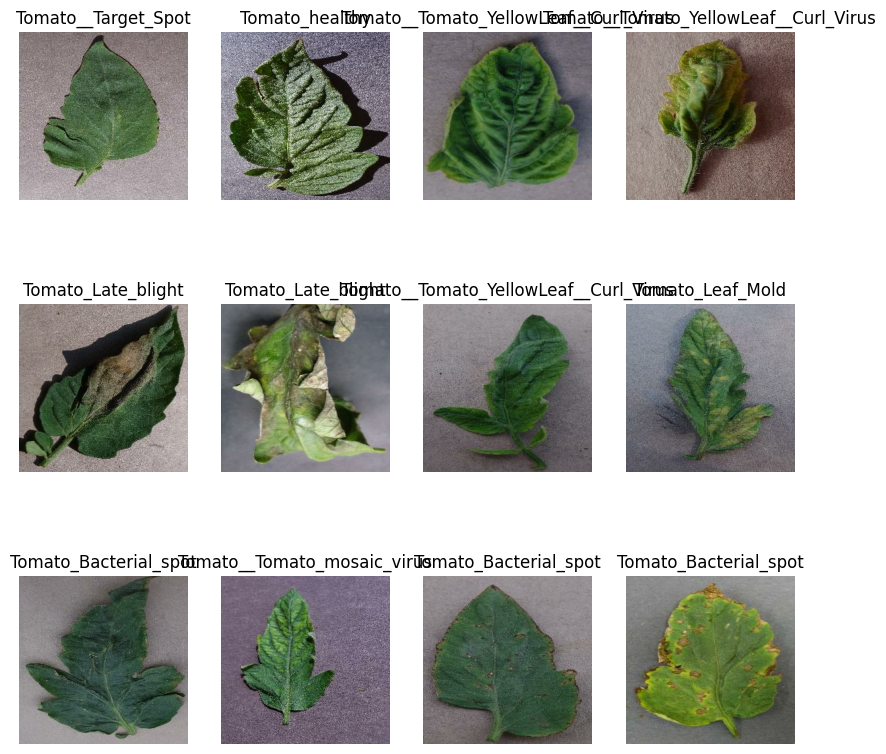

In [6]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

image visualization is done

In [7]:
# 80% ==> Training
# 20% ==> test
#     10% ==> Validation
#     10% ==> Test

In [8]:
train_size = 0.8
len(dataset)*train_size


800.8000000000001

In [9]:
train_ds = dataset.take(54) #this will take array arr[:54]
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

947

In [11]:
val_size=0.1
len(dataset)*val_size

100.10000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

941

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

800

In [17]:
len(val_ds)

100

In [18]:
len(test_ds)

101

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
for image_batch , labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.627451   0.60784316 0.59607846]
  [0.63529414 0.6156863  0.6039216 ]
  [0.63529414 0.6156863  0.6039216 ]
  ...
  [0.49019608 0.45882353 0.4509804 ]
  [0.5176471  0.4862745  0.47843137]
  [0.4745098  0.44313726 0.43529412]]

 [[0.5882353  0.5686275  0.5568628 ]
  [0.6039216  0.58431375 0.57254905]
  [0.6117647  0.5921569  0.5803922 ]
  ...
  [0.49411765 0.4627451  0.45490196]
  [0.52156866 0.49019608 0.48235294]
  [0.5176471  0.4862745  0.47843137]]

 [[0.5882353  0.5686275  0.5568628 ]
  [0.6117647  0.5921569  0.5803922 ]
  [0.62352943 0.6039216  0.5921569 ]
  ...
  [0.49019608 0.45882353 0.4509804 ]
  [0.5058824  0.4745098  0.46666667]
  [0.54901963 0.5176471  0.50980395]]

 ...

 [[0.60784316 0.57254905 0.54509807]
  [0.6117647  0.5764706  0.54901963]
  [0.61960787 0.58431375 0.5568628 ]
  ...
  [0.5176471  0.4745098  0.4509804 ]
  [0.5254902  0.48235294 0.45882353]
  [0.5372549  0.49411765 0.47058824]]

 [[0.6431373  0.60784316 0.5803922 ]
  [0.654902   0.61960787 0.5921569 ]


In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

now we will make the model

In [23]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 10
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size = (3,3),activation= 'relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation= 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape= input_shape)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (16, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (16, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (16, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (16, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (16, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (16, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (16, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (16, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (16, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (16, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (16, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (16, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (16, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (16, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 278,346 (1.06 MB)

 Trainable params: 278,346 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

now we will compile

In [25]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history=model.fit(
train_ds,
batch_size = BATCH_SIZE,
validation_data = val_ds,
verbose = 1,
epochs = EPOCHS
)

Epoch 1/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 78s 40ms/step - accuracy: 0.3675 - loss: 1.7883 - val_accuracy: 0.5100 - val_loss: 1.4128
Epoch 2/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.6679 - loss: 0.9384 - val_accuracy: 0.6137 - val_loss: 1.1068
Epoch 3/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.7685 - loss: 0.6533 - val_accuracy: 0.6381 - val_loss: 1.0712
Epoch 4/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8057 - loss: 0.5487 - val_accuracy: 0.6762 - val_loss: 1.0895
Epoch 5/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8391 - loss: 0.4579 - val_accuracy: 0.7750 - val_loss: 0.6050
Epoch 6/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8648 - loss: 0.3851 - val_accuracy: 0.8213 - val_loss: 0.5422
Epoch 7/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8828 - loss: 0.3278 - val_accuracy: 0.8562 - val_loss: 0.4204
Epoch 8/30
800/800 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.8843 - loss: 0.3269 - 

In [27]:
# len(test_ds)

In [28]:
# scores = model.evaluate(test_ds)

In [29]:
# scores

In [37]:
model.save("/kaggle/working/saved_model_tf", save_format='tf')

ValueError: The `save_format` argument is deprecated in Keras 3. Please remove this argument and pass a file path with either `.keras` or `.h5` extension.Received: save_format=tf

In [36]:
model.save_weights("/kaggle/working/model.weights.h5")

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

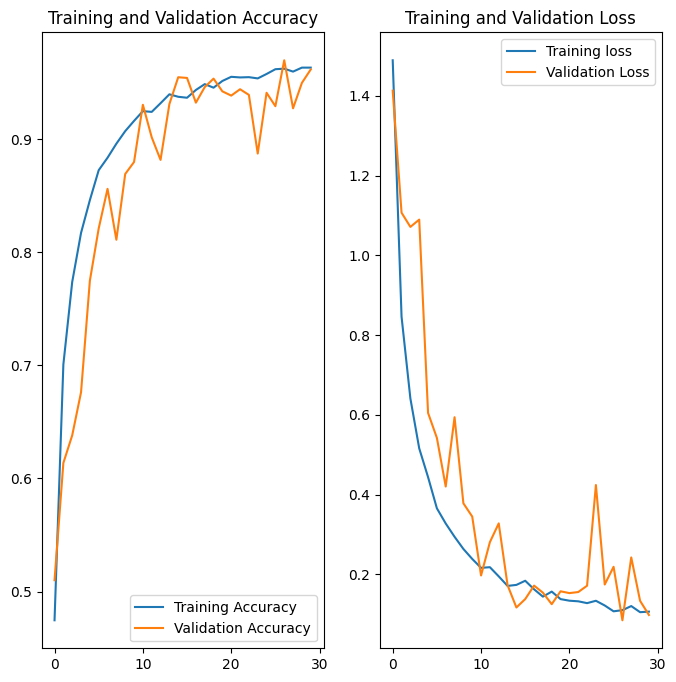

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training loss')
plt.plot(range(EPOCHS),val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import numpy as np

for images_batch,labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    
    print("First image to predict")
    plt.imshow(first_image)
    print("actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction = model_predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
# def predict(model ,img):
#     img_array = tf.keras.preprocessing.omage.img_to_array(images[i].numpy())
#     img_array = tf.expand_dims(img_array,0) #create a batch
    
#     predictions = model.predict(img_array)
    
#     predicted_class = class_names[np.argmax(predictions[0])]
#     confidence = round(100*(np.max(predictions[0])),2)
#     return predicted_class,confidence

In [ ]:
# plt.figure(figsize=(15,15))
# for images,labels in test_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3,3,i+1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         predicted_class,confidence = predict(model,images[i].numpy())
        
#         actual_class = calss_names[labels[i]]
#         plt.title(f"Actual : {actual_class} ,\n Predicted: {predicted_class}. \n Confidence: {confidence}%")
#         plt.axis("off")

the above code is for saving the version of the model